In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import scores
import flox
import matplotlib.pyplot as plt
test = ["2024_07", "2024_10", "2025_01", "2025_04", "2025_07"]
selected_months = test
AIFS_path = "/path/to/model_output/combined_lt/AIFS/calibrated_months/calibrated_precip"
HRES_path = "/path/to/model_output/combined_lt/HRES/calibrated_months/calibrated_precip"
paths = {"AIFS": AIFS_path, "HRES": HRES_path}

# Comparing characteristics of calibration

In [2]:
%%capture
vals = {}
for model in ["AIFS","HRES"]:
    months = []
    for m_y in selected_months:
        monthly = xr.load_dataset(f"{paths[model]}_{m_y}.nc")
        months.append(monthly)
        #print(monthly)
    # some slight differences in meta data between older and new AIFS data
    valset = xr.combine_by_coords(months, combine_attrs="override")
    vals[model] = valset
vals["AIFS"], vals["HRES"] = xr.align(vals["AIFS"], vals["HRES"], join="inner")

In [3]:
def expected_value(fcst_da):
    width = (
        fcst_da["threshold"]
        .diff("threshold")
        .assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    )
    mid = fcst_da["threshold"].isel(threshold=slice(None, -1)) + width * 0.5
    diff = fcst_da.diff(dim="threshold")
    if diff.mean() < 0:
        diff = -diff
    height = diff.assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    exp_val = (height * mid).sum("threshold", skipna=False)
    exp_val.attrs["units"] = fcst_da.attrs["units"]
    return exp_val

In [4]:
val_dfs = {}
for model in ["HRES","AIFS"]:
    fcast = vals[model]["probability_of_lwe_thickness_of_precipitation_amount_above_threshold"]
    expected_val = expected_value(fcast)
    val_dfs[model] = expected_val.to_dataframe(name="calibrated_forecast").reset_index()

Load in high rainfall observations then join

In [ ]:
AIFS_obs = pd.read_parquet("/path/to/extracted_sites/large_gauge_AIFS.parquet")
HRES_obs = pd.read_parquet("/path/to/extracted_sites/large_gauge_HRES.parquet")
obs = {"AIFS":AIFS_obs, "HRES": HRES_obs}

for model in ["HRES","AIFS"]:
    obs[model] = obs[model].rename(columns={"lwe_thickness_of_precipitation_amount":"raw_forecast","lwe_thickness_of_precipitation_amount_observed":"observed"})
    obs[model] = obs[model].merge(val_dfs[model], left_on = ["time", "forecast_period","site_id"], right_on=["time", "forecast_period","site_id"])

all_obs = obs["AIFS"].merge(obs["HRES"], left_on = ["time", "forecast_period","site_id"], right_on=["time", "forecast_period","site_id"], suffixes=('_AIFS','_HRES'))
all_obs_f = all_obs[["time","forecast_period","site_id","raw_forecast_AIFS","observed_AIFS","calibrated_forecast_AIFS","raw_forecast_HRES","observed_HRES","calibrated_forecast_HRES"]]

all_obs_24h = all_obs_f[all_obs_f["forecast_period"] == pd.Timedelta(1,unit="d")]
all_obs_24h.head()

,time,forecast_period,site_id,raw_forecast_AIFS,observed_AIFS,calibrated_forecast_AIFS,raw_forecast_HRES,observed_HRES,calibrated_forecast_HRES
0,2024-07-02 12:00:00,1 days,59151,0.008529,0.041600,0.011958,0.004547,0.041600,0.005674
1,2024-07-04 12:00:00,1 days,58198,0.004771,0.027200,0.006598,0.006069,0.027200,0.008316
2,2024-07-05 12:00:00,1 days,40068,0.004804,0.023501,0.006157,0.004719,0.023501,0.006005
3,2024-07-06 12:00:00,1 days,38026,0.009707,0.024200,0.010682,0.011776,0.024200,0.008878
4,2024-07-07 12:00:00,1 days,46144,0.023226,0.029600,0.026981,0.043819,0.029600,0.031248


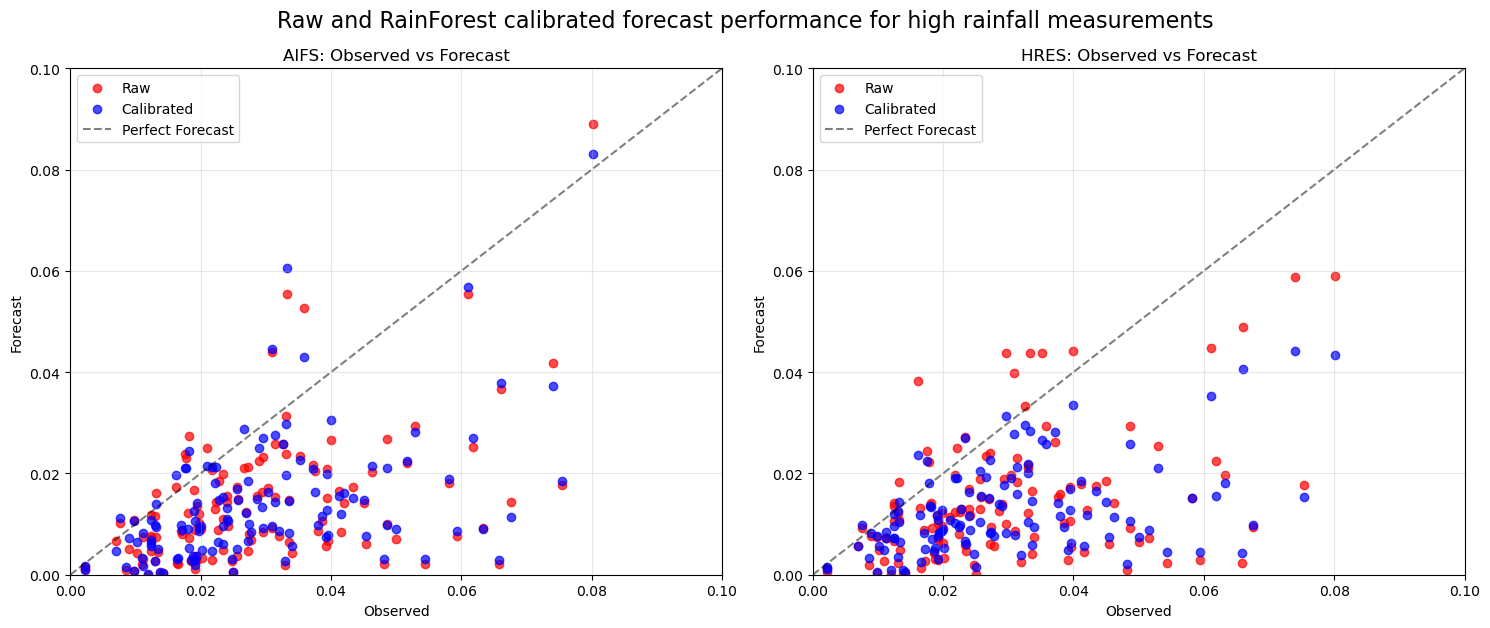

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df = all_obs_24h

lims = [
    0,
    0.1
]
# Plot AIFS
axes[0].scatter(df['observed_AIFS'], df['raw_forecast_AIFS'], label='Raw', color='red', alpha=0.7)
axes[0].scatter(df['observed_AIFS'], df['calibrated_forecast_AIFS'], label='Calibrated', color='blue', alpha=0.7)


# Plot HRES
axes[1].scatter(df['observed_HRES'], df['raw_forecast_HRES'], label='Raw', color='red', alpha=0.7)
axes[1].scatter(df['observed_HRES'], df['calibrated_forecast_HRES'], label='Calibrated', color='blue', alpha=0.7)


for i, model in enumerate(["AIFS","HRES"]):
    axes[i].plot(lims, lims, 'k--', alpha=0.5, label='Perfect Forecast')
    axes[i].set_title(f'{model}: Observed vs Forecast')
    axes[i].set_xlabel('Observed')
    axes[i].set_ylabel('Forecast')
    axes[i].legend()
    axes[i].set_xlim(lims[0],lims[1])
    axes[i].set_ylim(lims[0],lims[1])
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
fig.suptitle("Raw and RainForest calibrated forecast performance for high rainfall measurements", y=1.04, fontsize=16)
#plt.savefig("large_rainfall_days.png")
plt.show()

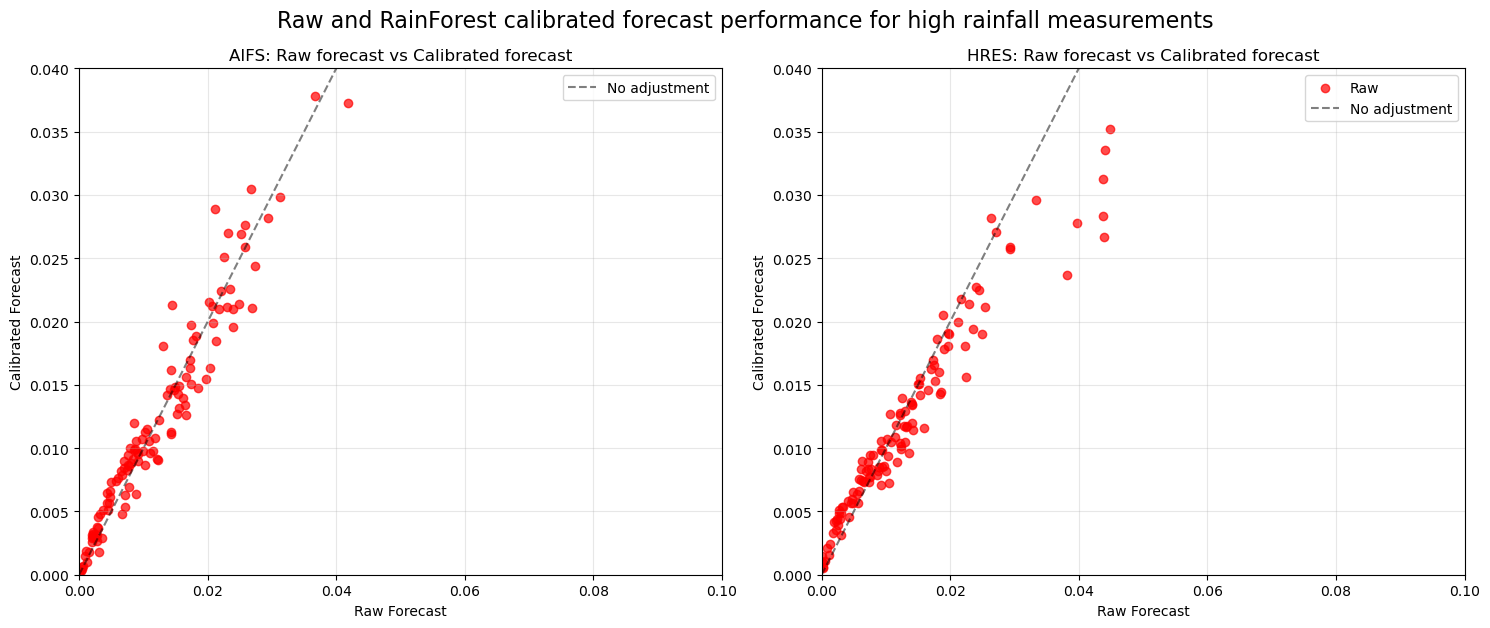

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df = all_obs_24h

lims = [
    0,
    0.1
]
# Plot AIFS
axes[0].scatter(df['raw_forecast_AIFS'], df['calibrated_forecast_AIFS'], label='', color='red', alpha=0.7)
# axes[0].scatter(df['observed_AIFS'], df['calibrated_forecast_AIFS'], label='Calibrated', color='blue', alpha=0.7)


# Plot HRES
axes[1].scatter(df['raw_forecast_HRES'], df['calibrated_forecast_HRES'], label='Raw', color='red', alpha=0.7)
#axes[1].scatter(df['observed_HRES'], df['calibrated_forecast_HRES'], label='Calibrated', color='blue', alpha=0.7)


for i, model in enumerate(["AIFS","HRES"]):
    axes[i].plot(lims, lims, 'k--', alpha=0.5, label='No adjustment')
    axes[i].set_title(f'{model}: Raw forecast vs Calibrated forecast')
    axes[i].set_xlabel('Raw Forecast')
    axes[i].set_ylabel('Calibrated Forecast')
    axes[i].legend()
    axes[i].set_xlim(lims[0],lims[1])
    axes[i].set_ylim(lims[0],0.04)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
fig.suptitle("Raw and RainForest calibrated forecast performance for high rainfall measurements", y=1.04, fontsize=16)
#plt.savefig("large_rainfall_days_xy.png", bbox_inches='tight')
plt.show()

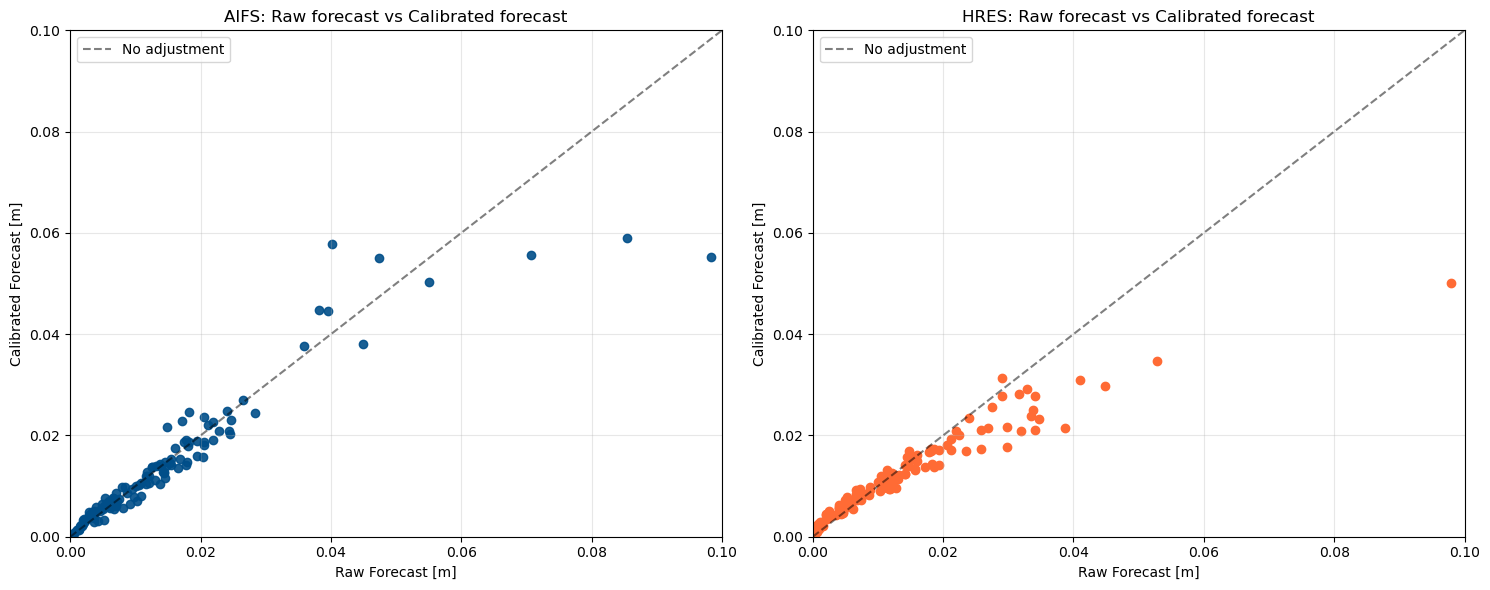

In [8]:
new_AIFS_colour = "#004E89"
old_AIFS_colour = "#8AC6D0"
new_HRES_colour = "#FF6B35"
old_HRES_colour = "#F7C59F"

n_days = 3
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df = all_obs_f[all_obs_f["forecast_period"] == pd.Timedelta(n_days,unit="d")]

lims = [
    0,
    0.1
]
# Plot AIFS
axes[0].scatter(df['raw_forecast_AIFS'], df['calibrated_forecast_AIFS'], color=new_AIFS_colour, alpha=0.9)
# axes[0].scatter(df['observed_AIFS'], df['calibrated_forecast_AIFS'], label='Calibrated', color='blue', alpha=0.7)


# Plot HRES
axes[1].scatter(df['raw_forecast_HRES'], df['calibrated_forecast_HRES'], color=new_HRES_colour)
#axes[1].scatter(df['observed_HRES'], df['calibrated_forecast_HRES'], label='Calibrated', color='blue', alpha=0.7)


for i, model in enumerate(["AIFS","HRES"]):
    axes[i].plot(lims, lims, 'k--', alpha=0.5, label='No adjustment')
    axes[i].set_title(f'{model}: Raw forecast vs Calibrated forecast')
    axes[i].set_xlabel('Raw Forecast [m]')
    axes[i].set_ylabel('Calibrated Forecast [m]')
    axes[i].legend()
    axes[i].set_xlim(lims[0],lims[1])
    axes[i].set_ylim(lims[0],0.1)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
# fig.suptitle("Raw and RainForest calibrated forecast performance for high rainfall measurements (10 day lead time)", y=1.04, fontsize=16)
plt.savefig(f"large_rainfall_days_{n_days}day.png", bbox_inches='tight', dpi=300)
plt.show()